This notebook will be used to investigate the event rates with respect to redshift. It will be using some of Lieke's code for binning the metallicites. 

The goal is to count how many systems are in each metallicity bin and plot them against the event rate

In [1]:
# all of the necessary imports
import h5py as h5  #importing, make sure the kernel is correct or the module will be unknown
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')

In [2]:
import sys
import os

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 


Let's get the WD+WD data

In [3]:
# reading in the HDF5 file
pathTorates_H5 = '/home/jovyan/home/rate_outputs/Rate_info_WDWD_1.h5' #path of the hdf5 file

Data_rates = h5.File(pathTorates_H5)

In [4]:
rates_info = Data_rates['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned']

In [5]:
# reading in the HDF5 file
pathToweights_H5 = '/home/jovyan/home/edit_hdf5/WDWD/v02.46.01/COMPAS_Output_wWeights.h5' #path of the hdf5 file

Data_weights = h5.File(pathToweights_H5)

In [6]:
# we want to read in the bse_RLOF to get information about thes different systems

DCO_WD_data = pd.DataFrame() # making a pandas dataframe

for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

    DCO_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

Let's just select for these systems in our dco table

In [90]:
# gathering the seeds from the rates.h5 file - this is for the WD+WD
dco_mask = rates_info['DCOmask'][()]
merging_all_WD = DCO_WD_data[dco_mask]
merging_all_WD

,CE_Event_Counter,Coalescence_Time,Eccentricity@DCO,Immediate_RLOF>CE,MT_Donor_Hist(1),MT_Donor_Hist(2),Mass(1),Mass(2),Merges_Hubble_Time,Metallicity@ZAMS(1),Optimistic_CE,Record_Type,Recycled_NS(1),Recycled_NS(2),SEED,SemiMajorAxis@DCO,Stellar_Type(1),Stellar_Type(2),Time,mixture_weight
463,1,64.106710,0.0,0,"b""b'8 '""","b""b'3 '""",0.483516,0.394784,1,0.000438,0,1,NaN,NaN,29,0.517110,11,11,1536.080151,7.360919
464,2,0.049491,0.0,0,"b""b'5 '""","b""b'3 '""",0.568929,0.211294,1,0.002140,0,1,NaN,NaN,86,0.074546,11,10,8874.314167,7.842265
465,1,8321.641517,0.0,0,"b""b'3 '""","b""b'5 '""",0.320580,0.526926,1,0.002418,0,1,NaN,NaN,87,1.677890,10,11,4428.913115,10.000000
466,1,441.783850,0.0,0,"b""b'1-2 '""","b""b'5-8 '""",0.276373,0.679873,1,0.012405,0,1,NaN,NaN,97,0.852472,10,11,1390.603090,9.999991
467,1,7164.965181,0.0,0,"b""b'2 '""","b""b'3 '""",0.527024,0.316107,1,0.000135,0,1,NaN,NaN,128,1.608598,11,10,3852.634168,9.992004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17486,1,325.360612,0.0,0,"b""b'2-8 '""","b""b'4-8 '""",1.083912,0.772944,1,0.000123,0,1,NaN,NaN,999745,1.354646,11,11,109.254748,0.298381
17487,2,2834.654788,0.0,0,"b""b'5 '""","b""b'3 '""",0.770769,0.396774,1,0.013625,0,1,NaN,NaN,999761,1.610884,11,11,940.615944,0.254697
17488,2,1073.100464,0.0,0,"b""b'6 '""","b""b'5 '""",0.954424,0.569040,1,0.000369,0,1,NaN,NaN,999871,1.558990,11,11,1787.995323,0.212650
17489,1,3009.383390,0.0,0,"b""b'2-8 '""","b""b'5-8 '""",0.773363,0.658614,1,0.004168,0,1,NaN,NaN,999912,1.954841,11,11,382.472452,0.160558


In [8]:
# let's look at if any of these systems RLOF post CE
np.sum(merging_all_WD['Immediate_RLOF>CE']==True)

np.int64(0)

Let's add the merger rate to this table

In [9]:
rates = rates_info['merger_rate']

for i in range(rates_info['merger_rate'][0,:].shape[0]):

    merging_all_WD['merger_rate_z'+str(i)] = rates_info['merger_rate'][:,i]

/tmp/ipykernel_92367/3880007837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merging_all_WD['merger_rate_z'+str(i)] = rates_info['merger_rate'][:,i]
/tmp/ipykernel_92367/3880007837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merging_all_WD['merger_rate_z'+str(i)] = rates_info['merger_rate'][:,i]
/tmp/ipykernel_92367/3880007837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Let's make different bins for metallicity. Let's look at how redshifts are split to get an intuition on how to bin these

In [10]:
redshifts = rates_info['redshifts']
display(redshifts[()])
display(redshifts)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9])

<HDF5 dataset "redshifts": shape (80,), type "<f8">

After looking at Lieke's code it seems like we need to find the mass evolved per metallicity to then correctly count how many systems merge at different redshifts

I know this is wrong because we are not considering the mass evolved per Z but let's count how many systems have a certain metallicity and make an 80 binned metallcity dist

In [91]:
# let's look at the ranges of metallicites we have
print('min metallicity=',np.min(merging_all_WD['Metallicity@ZAMS(1)']))
print('max metallicity=',np.max(merging_all_WD['Metallicity@ZAMS(1)']))
Z_bins = np.linspace(np.log10(np.min(merging_all_WD['Metallicity@ZAMS(1)'])),np.log10(np.max(merging_all_WD['Metallicity@ZAMS(1)'])),80)

min metallicity= 0.0001000075520179
max metallicity= 0.0299916009367008


Let's bin the metallicities evenly in log so that when we eventually normalize it, the average star formaing mass needed is just a constant

In [128]:
# let's first make our bins that we want that are evenly spaced in log
metallicities = np.array(merging_all_WD['Metallicity@ZAMS(1)'])
metallicities_log = np.log10(metallicities)
even_Z = np.linspace(np.min(metallicities_log), np.max(metallicities_log), 20)
bins_Z = even_Z
bins_Z

array([-3.9999672 , -3.86960053, -3.73923385, -3.60886717, -3.4785005 ,
       -3.34813382, -3.21776714, -3.08740047, -2.95703379, -2.82666712,
       -2.69630044, -2.56593376, -2.43556709, -2.30520041, -2.17483373,
       -2.04446706, -1.91410038, -1.7837337 , -1.65336703, -1.52300035])

We now want to count how many systems are in each of these metallicity bins

In [115]:
# # using value_counts to count how many systems fit into each bin
# print(np.log10(merging_all_WD['Metallicity@ZAMS(1)']).value_counts(sort=False,bins=20))

In [129]:
counts_bins = pd.cut(np.log10(merging_all_WD['Metallicity@ZAMS(1)']), bins=bins_Z).value_counts(sort=False)
counts_bins

Metallicity@ZAMS(1)
(-4.0, -3.87]        733
(-3.87, -3.739]      822
(-3.739, -3.609]     760
(-3.609, -3.479]     750
(-3.479, -3.348]     719
(-3.348, -3.218]     714
(-3.218, -3.087]     742
(-3.087, -2.957]     805
(-2.957, -2.827]     681
(-2.827, -2.696]     704
(-2.696, -2.566]     750
(-2.566, -2.436]     895
(-2.436, -2.305]    1025
(-2.305, -2.175]    1157
(-2.175, -2.044]    1380
(-2.044, -1.914]    1209
(-1.914, -1.784]    1049
(-1.784, -1.653]    1041
(-1.653, -1.523]    1091
Name: count, dtype: int64

In [130]:
counts_bins_array = np.array(counts_bins)
# counts_bins_reverse = list(reversed(counts_bins_array))
# counts_bins_reverse
sum(counts_bins_array) # missing a system?

np.int64(17027)

Text(0, 0.5, 'Number of WD+WD Systems')

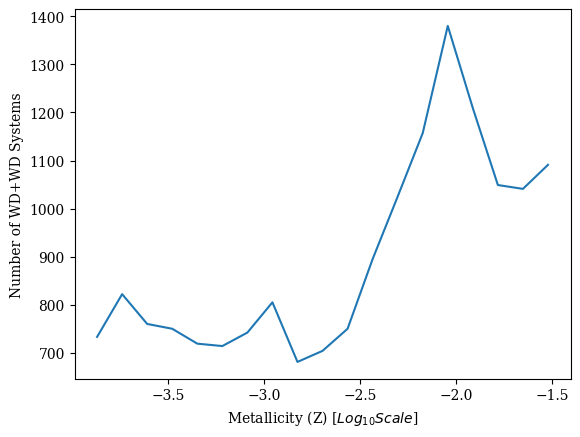

In [131]:
# need to take one less bin in the bins_Z array because the last bin is just anything greater than a certain metallicity
plt.plot(bins_Z[1:20], counts_bins_array)
plt.xlabel(r"Metallicity (Z) [$Log_{10} Scale$]")
plt.ylabel(r"Number of WD+WD Systems")

In [42]:
# labels = []
# for x in range(20):
#     labels.append('bin_'+str(x+1))

# df = pd.DataFrame()

# df['bin'] = pd.cut(metallicities_log, bins, labels=labels)

Let's try a less efficent way. but one that makes more sense to me to count the number of systems in each bin

In [112]:
# let's make empty lists that help count how many of each system fit within each bin

bin_1 = []
bin_2 = []
bin_2 = []
bin_3 = []
bin_4 = []
bin_5 = []
bin_6 = []
bin_7 = []
bin_8 = []
bin_9 = []
bin_10 = []
bin_11 = []
bin_12 = []
bin_13 = []
bin_14 = []
bin_15 = []
bin_16 = []
bin_17 = []
bin_18 = []
bin_19 = []
bin_20 = []

# counting how many systems are within each bin by looping through our metallicities 
for systems in merging_all_WD['Metallicity@ZAMS(1)']:
    if np.log10(systems) < bins_Z[0]:
        bin_1.append(1)
    if (np.log10(systems) > bins_Z[0]) and (np.log10(systems) < bins_Z[1]):
        bin_2.append(1)
    if (np.log10(systems) > bins_Z[1]) and (np.log10(systems) < bins_Z[2]):
        bin_3.append(1)
    if (np.log10(systems) > bins_Z[2]) and (np.log10(systems) < bins_Z[3]):
        bin_4.append(1)
    if (np.log10(systems) > bins_Z[3]) and (np.log10(systems) < bins_Z[4]):
        bin_5.append(1)
    if (np.log10(systems) > bins_Z[4]) and (np.log10(systems) < bins_Z[5]):
        bin_6.append(1)
    if (np.log10(systems) > bins_Z[5]) and (np.log10(systems) < bins_Z[6]):
        bin_7.append(1)
    if (np.log10(systems) > bins_Z[6]) and (np.log10(systems) < bins_Z[7]):
        bin_8.append(1)
    if (np.log10(systems) > bins_Z[7]) and (np.log10(systems) < bins_Z[8]):
        bin_9.append(1)
    if (np.log10(systems) > bins_Z[8]) and (np.log10(systems) < bins_Z[9]):
        bin_10.append(1)
    if (np.log10(systems) > bins_Z[9]) and (np.log10(systems) < bins_Z[10]):
        bin_11.append(1)
    if (np.log10(systems) > bins_Z[10]) and (np.log10(systems) < bins_Z[11]):
        bin_12.append(1)
    if (np.log10(systems) > bins_Z[11]) and (np.log10(systems) < bins_Z[12]):
        bin_13.append(1)
    if (np.log10(systems) > bins_Z[12]) and (np.log10(systems) < bins_Z[13]):
        bin_14.append(1)
    if (np.log10(systems) > bins_Z[13]) and (np.log10(systems) < bins_Z[14]):
        bin_15.append(1)
    if (np.log10(systems) > bins_Z[14]) and (np.log10(systems) < bins_Z[15]):
        bin_16.append(1)          
    if (np.log10(systems) > bins_Z[15]) and (np.log10(systems) < bins_Z[16]):
        bin_17.append(1)
    if (np.log10(systems) > bins_Z[16]) and (np.log10(systems) < bins_Z[17]):
        bin_18.append(1)
    if (np.log10(systems) > bins_Z[17]) and (np.log10(systems) < bins_Z[18]):
        bin_19.append(1)
    if (np.log10(systems) > bins_Z[18]):
        bin_20.append(1)

In [113]:
# let's make a new list that specifies how many systems are in each bin
counts_bin = [len(bin_1),len(bin_2),len(bin_3),len(bin_4),len(bin_5),len(bin_6),len(bin_7),len(bin_8),len(bin_9),len(bin_10),len(bin_11),\
              len(bin_12),len(bin_13),len(bin_14),len(bin_15),len(bin_16),len(bin_17),len(bin_18),len(bin_19),len(bin_20)]
counts_bin

[0,
 733,
 822,
 760,
 750,
 719,
 714,
 742,
 805,
 681,
 704,
 750,
 895,
 1025,
 1157,
 1380,
 1209,
 1049,
 1041,
 1091]

In [108]:
#let's make sure that we are counting all of the systems
print(sum(counts_bin)) # also missing a system?
print(np.shape(merging_all_WD))

17027
(17028, 20)


In [111]:
bins_Z

array([-3.9999672 , -3.86960053, -3.73923385, -3.60886717, -3.4785005 ,
       -3.34813382, -3.21776714, -3.08740047, -2.95703379, -2.82666712,
       -2.69630044, -2.56593376, -2.43556709, -2.30520041, -2.17483373,
       -2.04446706, -1.91410038, -1.7837337 , -1.65336703, -1.52300035])

Text(0, 0.5, 'Number of WD+WD Systems')

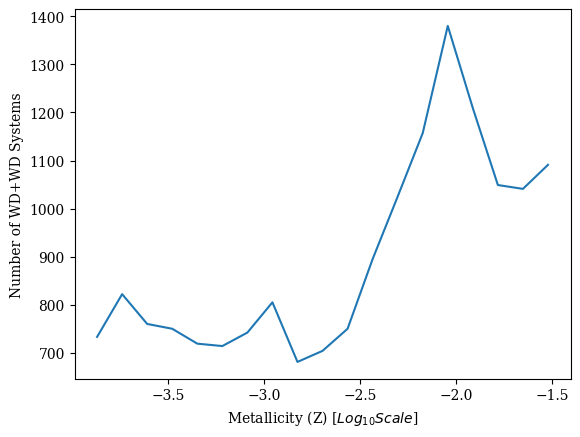

In [114]:
# let's plot our counts vs metallicities!

plt.plot(bins_Z[1:20], counts_bin[1:20])
plt.xlabel(r"Metallicity (Z) [$Log_{10} Scale$]")
plt.ylabel(r"Number of WD+WD Systems")

Both methods get me the same plot and values! We are just missing one system in each method